- https://everitt257.github.io/post/2018/08/10/object_detection.html
- https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9
- [Follow This for basic implementation](https://www.youtube.com/watch?v=4yOcsWg-7g8)
- [Simple RCNN Implementation](https://github.com/chingisooinar/Object-Detection_from-Scratch/blob/main/RCNN/RCNN.ipynb)

## Imports

In [200]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
%matplotlib inline
import glob
import os
from math import ceil
import random

import cv2
import PIL
from IPython.core.interactiveshell import InteractiveShell
from torchinfo import summary
InteractiveShell.ast_node_interactivity = "all"

from typing import *

# importing modules
import urllib.request
from urllib.request import urlopen
from PIL import Image

import bounding_boxes

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cpu


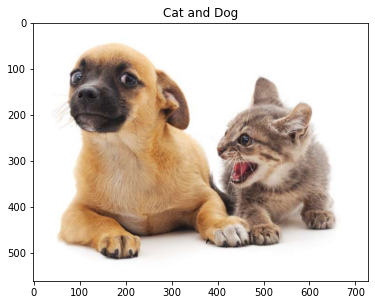

In [125]:
cat_dog_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/catdog.jpg"

# plot cat and dog with title using PIL
plt.figure(figsize=(6, 6))

cat_dog = PIL.Image.open(urlopen(cat_dog_p))
plt.imshow(cat_dog)
plt.title("Cat and Dog")
plt.show();

- Load the image and bbox in the correct format in np array and plot them;

In [126]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
# dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
# unsure why is not xmin ymin format tho.

dog_bbox, cat_bbox = [45.0, 60.0, 516.0, 378.0], [112.0, 400.0, 493.0, 655.0]
img = np.asarray(PIL.Image.open(urlopen(cat_dog_p)))
bboxes = np.asarray((dog_bbox, cat_bbox)).astype(int)
labels = np.array([1, 2]) # 0: background, 1: dog, 2: cat

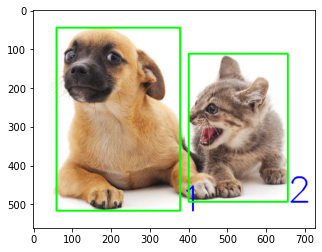

In [127]:
for i in range(len(bboxes)):
    cv2.rectangle(
        img,
        (bboxes[i][1], bboxes[i][0]),
        (bboxes[i][3], bboxes[i][2]),
        color=(0, 255, 0),
        thickness=3,
    )
    cv2.putText(
        img,
        str(int(labels[i])),
        (bboxes[i][3], bboxes[i][2]),
        cv2.FONT_HERSHEY_SIMPLEX,
        3,
        (0, 0, 255),
        thickness=3,
    )
plt.imshow(img)
plt.show();

- Our input to the Faster-RCNN should always be 800x800x3, so need to resize!

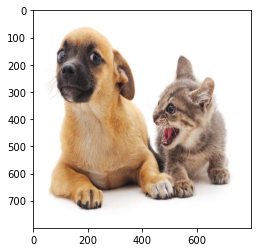

In [128]:
img = np.asarray(PIL.Image.open(urlopen(cat_dog_p)))
img_resized = cv2.resize(img, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img_resized)
plt.show()

- After resizing the image, the bbox must also be resized to reflect the new coordinates, we do it below;

In [129]:
# change the bounding box coordinates 
Wratio = 800/img.shape[1]
Hratio = 800/img.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bboxes_resized = []
for box in bboxes:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bboxes_resized.append(box)
bboxes_resized = np.asarray(bboxes_resized)
print(bboxes_resized)

[[ 64  65 735 415]
 [159 439 703 719]]


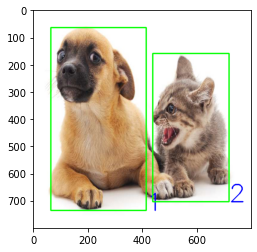

In [130]:
for i in range(len(bboxes)):
    cv2.rectangle(
        img_resized,
        (bboxes_resized[i][1], bboxes_resized[i][0]),
        (bboxes_resized[i][3], bboxes_resized[i][2]),
        color=(0, 255, 0),
        thickness=3,
    )
    cv2.putText(
        img_resized,
        str(int(labels[i])),
        (bboxes_resized[i][3], bboxes_resized[i][2]),
        cv2.FONT_HERSHEY_SIMPLEX,
        3,
        (0, 0, 255),
        thickness=3,
    )
plt.imshow(img_resized)
plt.show();

## Feature Extraction Step

- Use VGG16 to extract feature maps of the input image.
- This means we transform (1, 3, 800, 800) to (1, 512, 50, 50)

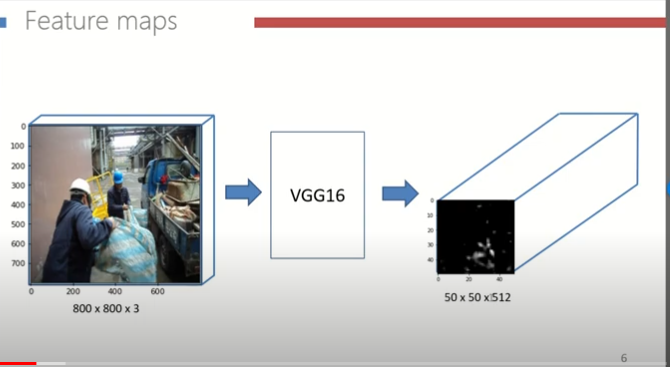

In [131]:
# List all the layers of VGG16
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)
vgg16
# vgg16.features

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [132]:
batch_size = 1
input_image = torch.rand(size=(3, 800, 800))

print(summary(vgg16, (batch_size, *input_image.shape)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 25, 25]          --
│    └─Conv2d: 2-1                       [1, 64, 800, 800]         1,792
│    └─ReLU: 2-2                         [1, 64, 800, 800]         --
│    └─Conv2d: 2-3                       [1, 64, 800, 800]         36,928
│    └─ReLU: 2-4                         [1, 64, 800, 800]         --
│    └─MaxPool2d: 2-5                    [1, 64, 400, 400]         --
│    └─Conv2d: 2-6                       [1, 128, 400, 400]        73,856
│    └─ReLU: 2-7                         [1, 128, 400, 400]        --
│    └─Conv2d: 2-8                       [1, 128, 400, 400]        147,584
│    └─ReLU: 2-9                         [1, 128, 400, 400]        --
│    └─MaxPool2d: 2-10                   [1, 128, 200, 200]        --
│    └─Conv2d: 2-11                      [1, 256, 200, 200]        29

- Basically we are taking the feature maps up until the last conv layer (exclude max pool). This is a typical step where by we cut off at the final conv layer to get the feature maps!
- We just subset all features from conv2d 2-1 to relu 2-30 which is just subset [0:-1] from vgg16 features method.


In [133]:
req_features = vgg16.features[0:-1]

In [134]:
# Convert this list into a Sequential module, 
faster_rcnn_fe_extractor = torch.nn.Sequential(*req_features)

In [135]:
# 測試看看 input image 通過 feature extractor 的結果
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img_resized).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


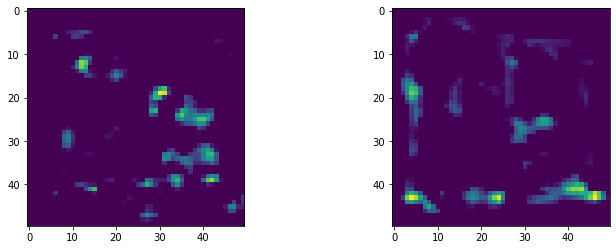

In [136]:
# visualize the first 5 channels of the 50*50*512 feature maps
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(2): 
    fig.add_subplot(1, 2, figNo) 
    plt.imshow(imgArray[i])
    figNo +=1
plt.show();

## Generate Anchor Boxes on Each Input Image

- 50x50=2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9=22,500

In [137]:
# x, y intervals to generate anchor box center
fe_size = 800 // 16 # 50
ctr_x = np.arange(16, (fe_size + 1) * 16, 16)
ctr_y = np.arange(16, (fe_size + 1) * 16, 16)
print(len(ctr_x), ctr_x)
print(len(ctr_y), ctr_y)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [138]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


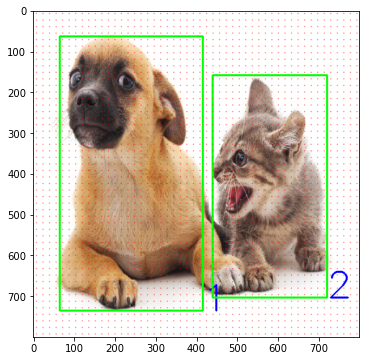

In [139]:
# display the 2500 anchors

plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_resized, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_resized)
plt.show();

In [140]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


In [141]:

def plot_anchor_boxes(
    anchor_boxes, bboxes, image, anchor_bboxes_range: Callable
):
    image_clone = np.copy(image)
    # display the 9 anchor boxes of one anchor and the ground truth bbox
    plt.figure(figsize=(9, 6))
    for i in anchor_bboxes_range:  # 9*1225=11025
        x0 = int(anchor_boxes[i][1])
        y0 = int(anchor_boxes[i][0])
        x1 = int(anchor_boxes[i][3])
        y1 = int(anchor_boxes[i][2])
        cv2.rectangle(
            image_clone, (x0, y0), (x1, y1), color=(0, 0, 0), thickness=3
        )

    for i in range(len(bboxes)):
        cv2.rectangle(
            image_clone,
            (bboxes[i][1], bboxes[i][0]),
            (bboxes[i][3], bboxes[i][2]),
            color=(0, 255, 0),
            thickness=3,
        )  # Draw Rectangle

    plt.imshow(image_clone)
    plt.show()

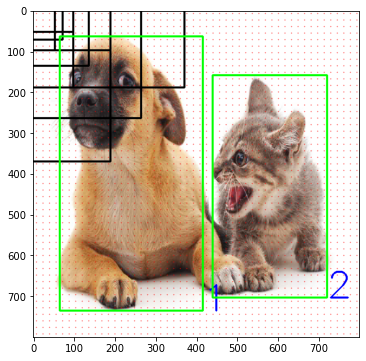

In [145]:
anchor_bboxes_range = range(0, 9)
plot_anchor_boxes(anchor_boxes, bboxes_resized, img_resized, anchor_bboxes_range)

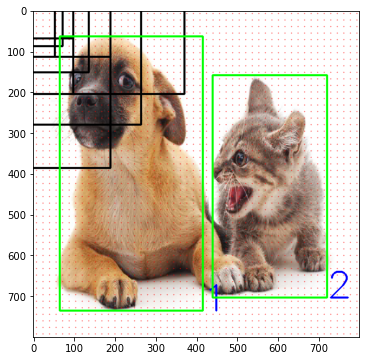

In [146]:
anchor_bboxes_range = range(9, 18)
plot_anchor_boxes(anchor_boxes, bboxes_resized, img_resized, anchor_bboxes_range)

- This 9 anchor boxes are the centered around the center pixel.

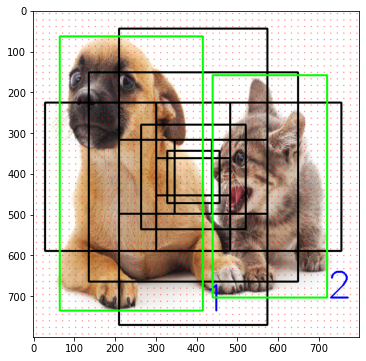

In [144]:
anchor_bboxes_range = range(11025, 11034) #9*1225=11025 middle pixel's anchor box
plot_anchor_boxes(anchor_boxes, bboxes_resized, img_resized, anchor_bboxes_range)

- Out of 22500 anchor boxes, we need to discard some anchor boxes, because due to the generating algorithm, some anchor boxes might be outside of the 800 by 800 image.
- After discarding we have 8940 anchor boxes left.
- I believe if you tune the `ratios = [0.5, 1, 2]` and `scales = [8, 16, 32]` you will get different results for valid anchor boxes.

In [152]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


## IOU of Anchor Box and True Bounding Boxes!

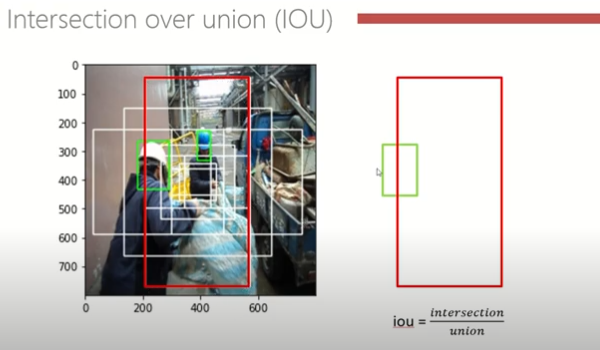

- Calculate iou of the valid anchor boxes with each ground truth bbox.
- Since there are 8940 valid anchor boxes and only 2 ground truth bbox per this image, then 
- Our final `ious` should be an array of (8940, 2) where column 1 is the ious of each anchor box with bbox 1 (dog gt bbox) and column 2 is the ious of each anchor box with bbox 2 (the cat gt bbox)
- Note this is batch size of 1, so it is easy to see, but in reality each image has different number of gt bboxes! So take note the shape won't always be (8940, 2)

In [154]:
# Calculate iou of the valid anchor boxes 
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bboxes_resized):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8940, 2)


- For eg, [0.01919497, 0] means the cat bbox and the anchor bbox has 0 intersection.

In [158]:
ious 

array([[0.01919497, 0.        ],
       [0.02159903, 0.        ],
       [0.02401446, 0.        ],
       ...,
       [0.        , 0.0157947 ],
       [0.        , 0.01381642],
       [0.        , 0.01184583]], dtype=float32)

- gt_argmax_ious: at row 1850 and 6846, we note that they have the highest IOU. We used `argmax` on the axis 0 column wise, means for each column, we find out which index has the highest IOU score.
- gt_max_ious: We put these two max ious (1 for dog 1 for cat) into an array [0.886.., 0.581..]
- gt_argmax_ious: We further see if there's other indexes with the highest IOUs because there can be tie when you use argmax.

In [156]:
# What anchor box has max iou with the ground truth bbox
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1850 6846]
[0.8863183 0.5810547]
[1850 1857 1864 1871 2078 2085 2092 2099 6846 6853 6860 6867 7074 7081
 7088 7095 7302 7309 7316 7323 7530 7537 7544 7551 7758 7765 7772 7779]


- argmax_ious: this means for each row, we compare the two IOUs and take the largest IOU, then assign to the index:
- For example the first 3 rows of ious are
```python
([[0.01919497, 0.        ],
   [0.02159903, 0.        ],
   [0.02401446, 0.        ],
```

note each row is the anchor box IOU with the 2 gt, so for 1st row, the anchor bbox has some iou with dog as compared to the iou of it with the cat bbox, so we take the index to be 0, else index is 1.

- max_ious: take the highest IOU for each row and reduce it to 1 column.

In [157]:
# What ground truth bbox is associated with each anchor box 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 1 1 1]
[0.01919497 0.02159903 0.02401446 ... 0.0157947  0.01381642 0.01184583]


- Let us plot some of these anchor boxes!! Note we change the input argument to `valid_anchor_boxes` now since we are looking at the valid ones.
- Let us plot 1850's anchor box by specifying the range from 1850 - 1851. Lo and behold the dog highest bbox is indeed quite good.

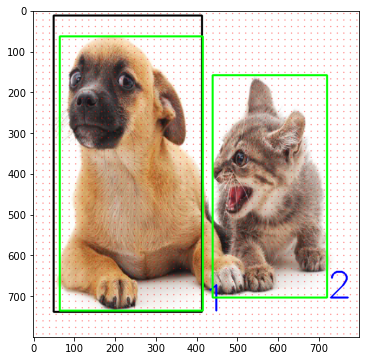

In [173]:
anchor_bboxes_range = range(1850, 1851) #9*1225=11025 middle pixel's anchor box
plot_anchor_boxes(valid_anchor_boxes, bboxes_resized, img_resized, anchor_bboxes_range)

- Let us plot some of these anchor boxes!! Note we change the input argument to `valid_anchor_boxes` now since we are looking at the valid ones.
- Let us plot 6846's anchor box by specifying the range from 6846 - 6847. Lo and behold! The cat highest bbox isnt as good but ok.

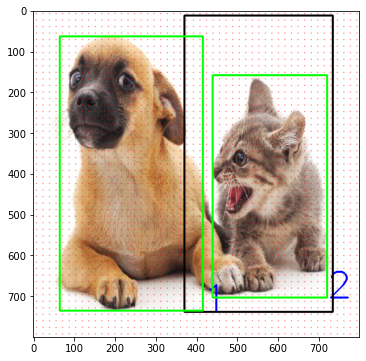

In [174]:
anchor_bboxes_range = range(6846, 6847) #9*1225=11025 middle pixel's anchor box
plot_anchor_boxes(valid_anchor_boxes, bboxes_resized, img_resized, anchor_bboxes_range)

## Use the IOU value to assign **LABELS** TO EACH VALID ANCHOR BOX (**IMPORTANT**)

- See D2L:
- Using the c (512) length- feature vector at the center of each anchor box, predict the binary class (background or objects) and bounding box for this anchor box.
- So, if IOU is more than a threshold say 0.7, then it is an object which we assign 1, if less than say 0.3, then assign it as background 0, and if between 0.3 and 0.7 we ignore and assign -1.

> This step is important and clears confusion of how **labels** were assigned to each anchor box very important!

In [162]:
# 把 8940 個 valid anchor boxes 的標籤先統一設為 -1 (ignore)
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [163]:
# Use iou to assign 1 (objects) to two kind of anchors 
# a) The anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

We see that there are only a few anchor boxes left that really has an object, the rest is background or ignore.

In [167]:
np.where(label==1)

(array([1394, 1401, 1408, 1415, 1622, 1629, 1636, 1643, 1850, 1857, 1864,
        1871, 2078, 2085, 2092, 2099, 2314, 2322, 2330, 2338, 2560, 2568,
        2576, 2584, 6846, 6853, 6860, 6867, 7074, 7081, 7088, 7095, 7302,
        7309, 7316, 7323, 7530, 7537, 7544, 7551, 7758, 7765, 7772, 7779],
       dtype=int64),)

## Mini-Batch 256

- Batch size 256 this is not the batch size of the image but batch size of the anchor boxes
- So there are 8940 valid anchor boxes, we take 256 from them randomly and such that 128 of them are object of 1 and 128 to be background 0 and the remaining is -1
- Note that I only have 44 valid anchor boxes with "object" 1 that's ok, we just label all others to be -1.

In [181]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
print(neg_index.shape)
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

(7842,)


## Transform Valid Anchor Boxes Format from (y1, x1, y2, x2) to the correct format


In [182]:
# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bboxes_resized[argmax_ious]
print(max_iou_bbox.shape)

# valid anchor boxes 的 h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# valid anchor box 的 max iou 的 bbox 的 h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #讓 height !=0, 最小值為 eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


## Region Proposal Network

- So now we must be clear, we have labelled 8940 valid anchor boxes with the **TRUE ANSWER Y** labels: i.e. some have object we give it a binary class of 1 some dont have we give it 0, some we want to ignore we give it -1
- So now back to our 22500 anchor boxes, we label all the "invalid anchor bboxes" to be -1 also cause we want to ignore them as well.
- Note that we are in a mini-batch of 256 anchor boxes so our RPN focuses on this 256 for now.
- See image below the $y$ and $\hat{y}$ indicates the gt and predicted.

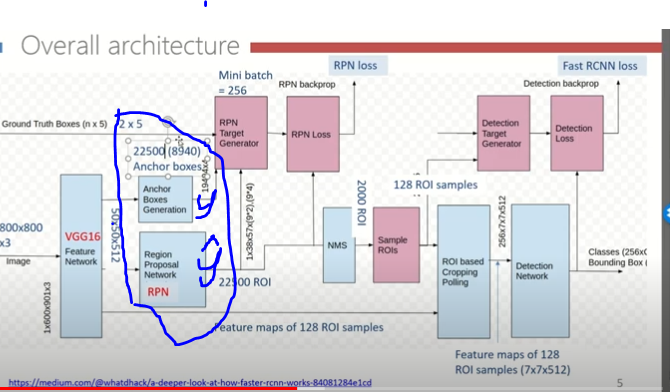



- NOTICE: 每個 training epoch, 我們從 8940 個 valid anchor boxes 隨機選 128 個 positive + 128個 negative, 其他都標-1

In [183]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


### Send Feature Maps to RPN to produce 22500 Regions of Interests (ROIs)

- Send the feature maps to the RPN
- Recall `out_map = faster_rcnn_fe_extractor(imgTensor)` where we already send the image tensor through the feature extractor and has shape of `[1, 512, 50, 50]`.
- So now we will concat some layers after the feature map `out_map`.

In [184]:
out_map = faster_rcnn_fe_extractor(imgTensor)
out_map.shape

torch.Size([1, 512, 50, 50])

In [188]:
in_channels = 512  # depends on the output feature map. in vgg 16 it is equal to 512

mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)  # I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_();


In [189]:
x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
print(x.shape)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 512, 50, 50])
torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


- `reg_layer`: has 9*4 = 36 filters in this layer and therefore outputs [1, 36, 50, 50] shape since padding is same with stride 1.
    - because recall there are 2500 anchors points (not boxes), and there are 2500 * 9 = 22500 anchor boxes, so each anchor box has 4 values so this can be reshaped from (36, 50, 50) to (22500, 4), which is exactly what we want for the regression layer to calculate the loss of localization of the predicted anchor boxes from RPN vs true anchor boxes.

- `cls_layer`: in turn this has only [1, 18, 50, 50] shape because it can be reshaped to [22500, 2] since we only want binary classification from RPN to predict whether there exist an object 1 or not 0.

In [192]:
# 轉換 RPN 預測 anchor box 的位置與分類之 format 
# 位置: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# 分類: [1, 18(9*2), 50, 50] => [1, 22500, 2]  (1, 0)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


### RPN LOSS

- Localization loss uses regression with smooth L1 Loss
- Objectness Classification uses CE Loss

In [195]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [201]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [202]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.7012, grad_fn=<NllLossBackward0>)


In [203]:
# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([44, 4]) torch.Size([44, 4])
tensor(1.2859, dtype=torch.float64, grad_fn=<SumBackward0>)


In [204]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(0.9935, dtype=torch.float64, grad_fn=<AddBackward0>)


## NMS

In [205]:
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [206]:
# The labelled 22500 anchor boxes 
# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] #每個 anchor box 的 dy
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(dy.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [207]:
# 用 labelled 的 anchor boxes 與 RPN 預測的 anchor boxes來計算 ROI = [y1, x1, y2, x2] 
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [208]:
# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [209]:
# Take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# Find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [210]:
#Take the indexes of order the probability score in descending order 
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep 
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


## Sample 128 From NMS's 2000 ROIs

In [211]:
n_sample = 128  # Number of samples from roi 
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5  # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [213]:
# Find the iou of each ground truth object with the region proposals, 
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bboxes_resized):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [214]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 0 1 ... 0 0 0]
[0.16893381 0.         0.02414654 ... 0.280571   0.06312128 0.07249717]
[2 1 2 ... 1 1 1]


In [215]:
# Select the foreground rois as per the pos_iou_thesh and 
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

25
[1586 1678 1453 1905  715 1738  395 1342  122   19  561  672 1591  136
 1640  347 1574  568  255 1779  199 1957 1736 1405 1609]
103
[ 534 1181 1987 1226  441  808  397   43  406 1372 1133 1332 1783  744
  824  939  562 1178 1089  595  558 1353 1470 1995  538  491  477 1224
 1208 1359  743 1799  674  290 1944  962 1806  681  192 1824  249 1452
  914  547   69  107  303 1304 1711 1986  911 1197  489 1033   94 1334
  806  187 1996  708 1657 1659 1688 1011 1196  225  403  509  282  401
  409  440   95  892 1321  133 1096  334  153 1923 1873  770 1291  734
  143 1680  475  418 1555 1950 1039 1382  298 1067 1965 1525 1255  330
  832 1485  212 1114 1487]


- Here displays ROI samples with positive class 1; meaning there is object.

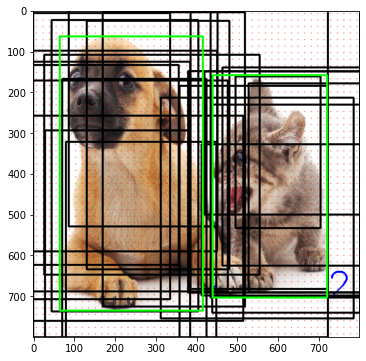

In [222]:
# display ROI samples with postive 
img_clone = np.copy(img_resized)
plt.figure(figsize=(9, 6))
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0,0,0), thickness=3) 

for i in range(len(bboxes_resized)):
    cv2.rectangle(img_clone, (bboxes_resized[i][1], bboxes_resized[i][0]), (bboxes_resized[i][3], bboxes_resized[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show();

- Here displays ROI samples with negative class 0; meaning there is no object, background

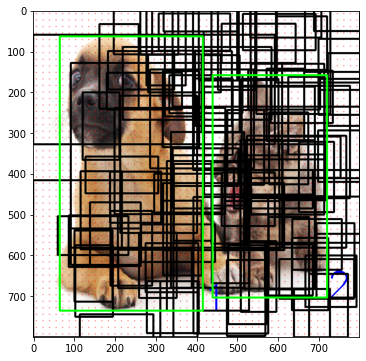

In [221]:
# display ROI samples with negative 
img_clone = np.copy(img_resized)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0,0,0), thickness=3) 

for i in range(len(bboxes_resized)):
    cv2.rectangle(img_clone, (bboxes_resized[i][1], bboxes_resized[i][0]), (bboxes_resized[i][3], bboxes_resized[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show(); 

In [223]:
# Now we gather positve samples index and negitive samples index, 
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bboxes_resized[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [224]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## 128 ROI Samples' Features and Pool them 

In [226]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [228]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [230]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size());

torch.Size([128, 512, 7, 7])


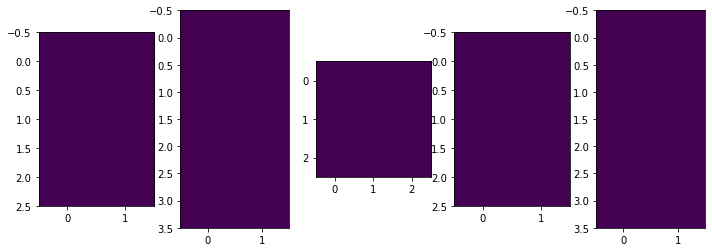

In [231]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp)
    figNo +=1
plt.show();

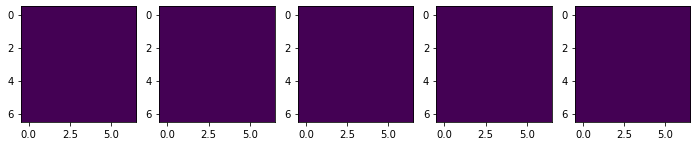

In [232]:
# Visualize the first 5 ROI's feature maps after ROI pooling (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp)
    figNo +=1
plt.show();

In [233]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


## PyTorch Pre-trained model

In [238]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [237]:
# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
print(labels.shape)

torch.Size([4, 11])


In [ ]:

>>> targets = []
>>> for i in range(len(images)):
>>>     d = {}
>>>     d['boxes'] = boxes[i]
>>>     d['labels'] = labels[i]
>>>     targets.append(d)
>>> output = model(images, targets)
>>> # For inference
>>> model.eval()
>>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
>>> predictions = model(x)